# Torch

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import re
%store -r __wideboy

In [3]:
__wideboy

# A General Similarity
### Torch

In [18]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
out1 = (a+a)*b
out2 = a.dot(b)

print(out1)
print(out2)

tensor([  8,  20,  36])
tensor(32)


# A More Complex Model
### Torch CNN

![title](modelClean.png)

# Data Loaders
### Torch

In [6]:
def loadData(data_func,directory,in_size,batch_size):
    train= data_func(directory, 
        train=True, 
        download=True,
        transform=transforms.Compose([
            transforms.Resize((in_size,in_size)),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))]
            ))
    test= data_func(directory,
        train=False,
        download=False,
        transform=transforms.Compose([
            transforms.Resize((in_size,in_size)),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))]
            ))
                          
    train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size, shuffle=True)
    test_loader  = torch.utils.data.DataLoader(test,batch_size=batch_size, shuffle=False)
    return train_loader,test_loader

# Model Helpers
### Torch

In [7]:
class nn_View(nn.Module):
    def __init__(self):
        super(nn_View, self).__init__()
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
def getDimStr(x):
    return "("+str(x.shape).replace("torch.Size([1,","")[:-2].strip()+")"

#get clean layer name
def getLabel(label):
    funcName = label.split("(")[0]
    nums = re.findall(r'\d+',label)

    if "Conv" in label:
        return funcName+"_"+nums[2]
    elif "Linear" in label:
        return funcName+"_"+nums[0]
    else:
        return funcName   

# Model Definitions
### Torch

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.params = nn.ModuleList()
        
        #CONV 1
        self.params+= [nn.Conv2d(1, 16, kernel_size=3,padding=1),
                       nn.BatchNorm2d(16),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(4)]
        
        #CONV 2
        self.params+= [nn.Conv2d(16, 32, kernel_size=3,padding=1),
                       nn.BatchNorm2d(32),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(4)]

        #RESHAPE
        self.params+= [nn_View()]
        
        #FC 
        self.params+= [nn.Dropout(),
                       nn.Linear(32, 32),
                       nn.ReLU(inplace=True)]
        
        #OUTPUT
        self.params+= [nn.Linear(32, 10),
                       nn.Softmax(dim=1)]
    
    def forward(self,x):
        for layer in self.params:
            x=layer(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def show(self,inSize):
        print("\n===MODEL===")
        rowFormat="{:<15}{:<15} -> {:<15}{:<15}"
        print(rowFormat.format("Layer Name","Input Size","Output Size","# Params"))
        print("============================================================")
        x=torch.zeros(inSize)
        paramCounts = []

        for layer in model.params:
            paramCount = sum([p.numel() for p in layer.parameters()])
            paramCounts.append(paramCount)
            labelStr  = getLabel(str(layer))+":"
            startSize = getDimStr(x)
            x=layer(x)
            print(rowFormat.format(labelStr,startSize,getDimStr(x),paramCount))

            if "MaxPool" in labelStr:
                print()
                
        print("============================================================")
        print("Total Parameters:","{:,}".format(sum(paramCounts)))
        print("============================================================")
        print()

# Train/Test Functions
### Torch

In [9]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    print()
    losses=[]
    for batch_idx, (data, target) in enumerate(train_loader):

        #train step
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))

        if batch_idx % 5 == 0:
            print('{:<15}{:<5} [{:>6}/{:<6} ({:>3.0f}%)]    Loss: {:<10.6f}'.format(
                "Train Epoch:",epoch, batch_idx * len(data), 
                len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()),
                end="\r",flush=True)
    return losses

#model test       
def test(model, device, test_loader,epoch):
    model.eval()
    test_loss= 0
    corrects = 0
    with torch.no_grad():
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device)
            output=model.forward(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.max(1, keepdim=True)[1]
            corrects += pred.eq(target.view_as(pred)).sum().item()

    test_loss = np.round(test_loss/len(test_loader.dataset),2)
            
    print()
    print('{:<15}{:<5} [{:>6}/{:<6} ({:>3.0f}%)]    Loss: {:<10.6f}'.format(
        "Test Epoch:",epoch, corrects,
        len(test_loader.dataset),
        100.* corrects/len(test_loader.dataset),
        test_loss.item()),
        end="\r",flush=True)

    return test_loss

# Set Parameters
### Torch

In [10]:
epochs = 10
device = torch.device('cpu')
lr = .05
momentum=.9
batch_size = 200
in_size = 16
train_losses,test_losses = [],[]


train_loader,test_loader = loadData(datasets.MNIST,"dataMNIST",batch_size=batch_size,in_size=in_size)

# Train Loop
### Torch

In [11]:
model = Net().to(device)
model.show((1,1,in_size,in_size))

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

print("===TRAINING===")
for epoch in range(0, epochs + 1):
    train_losses+=train(model,device, train_loader, criterion, optimizer, epoch)
    test_losses.append(test(model,device,test_loader,epoch))


===MODEL===
Layer Name     Input Size      -> Output Size    # Params       
Conv2d_16:     (1, 16, 16)     -> (16, 16, 16)   160            
BatchNorm2d:   (16, 16, 16)    -> (16, 16, 16)   32             
ReLU:          (16, 16, 16)    -> (16, 16, 16)   0              
MaxPool2d:     (16, 16, 16)    -> (16, 4, 4)     0              

Conv2d_32:     (16, 4, 4)      -> (32, 4, 4)     4640           
BatchNorm2d:   (32, 4, 4)      -> (32, 4, 4)     64             
ReLU:          (32, 4, 4)      -> (32, 4, 4)     0              
MaxPool2d:     (32, 4, 4)      -> (32, 1, 1)     0              

nn_View:       (32, 1, 1)      -> (32)           0              
Dropout:       (32)            -> (32)           0              
Linear_32:     (32)            -> (32)           1056           
ReLU:          (32)            -> (32)           0              
Linear_32:     (32)            -> (10)           330            
Softmax:       (10)            -> (10)           0              
Total Para

KeyboardInterrupt: 

# Evaluate
### Torch

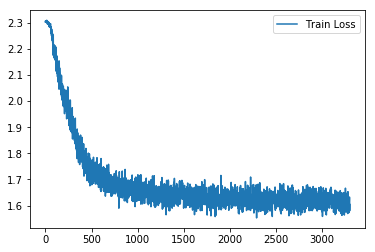

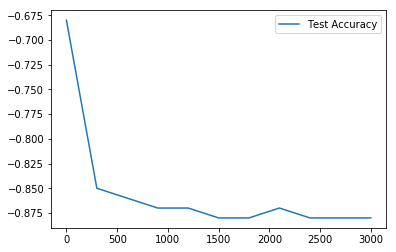

In [15]:
plt.plot(np.arange(len(train_loader)*(epochs+1)),train_losses,label="Train Loss")
plt.legend()
plt.show()
plt.plot(np.arange(epochs+1)*len(train_loader),test_losses,label="Test Accuracy")
plt.legend()
plt.show()